In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
out_files = []
update_list = []

## Helper functions

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [8]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [9]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [10]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [11]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [12]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
        
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs

    return adata

In [13]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Cluster selection functions

In [14]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [15]:
def extract_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )

    sel_idx = adata.obs[clusters].isin(sel_cl)
    n_extracted = sum(sel_idx)
    
    sel_adata = adata[sel_idx]
    
    return sel_adata, n_extracted

In [16]:
def remove_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )

    remove_idx = adata.obs[clusters].isin(sel_cl)
    n_removed = sum(remove_idx)
    keep_idx = [not x for x in remove_idx]

    adata = adata[keep_idx]
    
    return adata, n_removed

## Processing function

In [17]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Markers for dotplots

In [18]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [19]:
class_markers = [
    'CD4',
    'CD8A',
    'CD27',
    'GZMB',
    'GZMK',
    'IFI44L',
    'KLRF1',
    'SOX4'
]

## Read cell type hierarchy

In [20]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [21]:
search_id = 'tantalum-silicon-mendelevium'

Retrieve files stored in our HISE project store

In [22]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [23]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [24]:
search_df['AIFI_L3'].tolist()

['CD8aa',
 'CM CD8 T cell',
 'Core naive CD8 T cell',
 'GZMK- CD27+ EM CD8 T cell',
 'GZMK+ CD27+ EM CD8 T cell',
 'ISG+ memory CD8 T cell',
 'ISG+ naive CD8 T cell',
 'KLRF1- GZMB+ CD27- EM CD8 T cell',
 'KLRF1+ GZMB+ CD27- EM CD8 T cell',
 'SOX4+ naive CD8 T cell']

# Filter

## Filter GZMK- CD27+ EM CD8 T cell

### Proposed updates

- Reassign GZMK+ cluster as GZMK+ CD27+ EM CD8 T cell

In [25]:
cell_type = 'GZMK- CD27+ EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [26]:
type_uuid

'bdb7cc5d-0812-43e2-a250-962224f3e2d6'

In [27]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [28]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

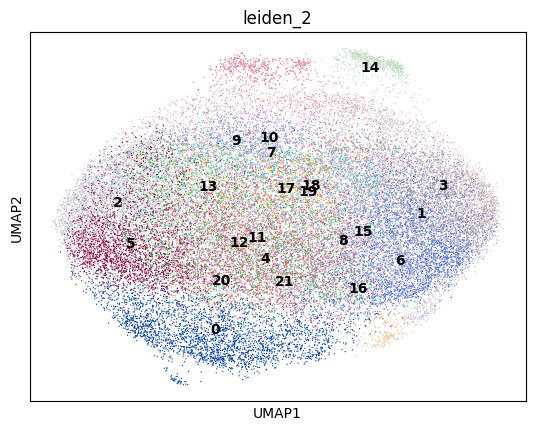

In [29]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

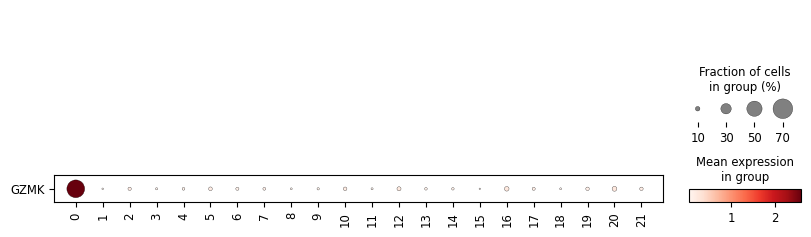

In [30]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['GZMK'], swap_axes = True)

### GZMK selection

In [31]:
em_gzmk_adata, n_extracted = extract_cl(
    adata, 'GZMK', 'above', 0.5, 'leiden_2'
)
em_gzmk_adata.obs['AIFI_L3'] = 'GZMK+ CD27+ EM CD8 T cell'
n_extracted

3193

**Reassigned cells will be added to GZMK+ cells below**

### GZMK removal

In [32]:
adata, n_removed = extract_cl(
    adata, 'GZMK', 'above', 0.5, 'leiden_2'
)
n_removed

3193

### Store reason for change

In [33]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['GZMK+ CD27+ EM CD8 T cell']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [34]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


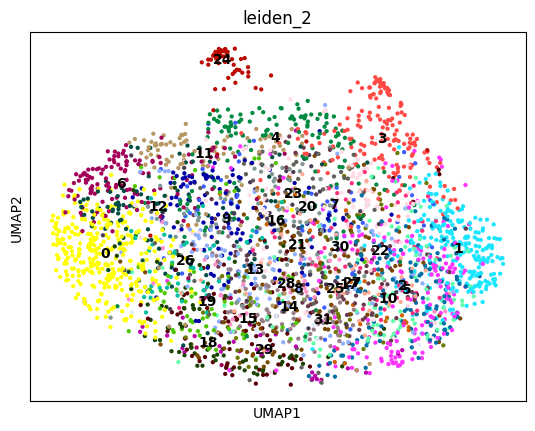

In [35]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [36]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Filter KLRF1- GZMB+ CD27- EM CD8 T cell

### Proposed updates

- Reassign IFI44L-high cluster as ISG+ memory CD8 T cell
- Remove HBA1-high cluster as Erythrocyte doublet

In [37]:
cell_type = 'KLRF1- GZMB+ CD27- EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [38]:
type_uuid

'b5bf5444-4f61-4775-99d3-f0b708ba3952'

In [39]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [40]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

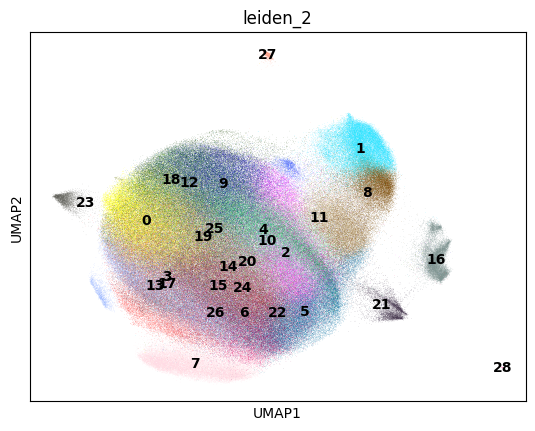

In [41]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

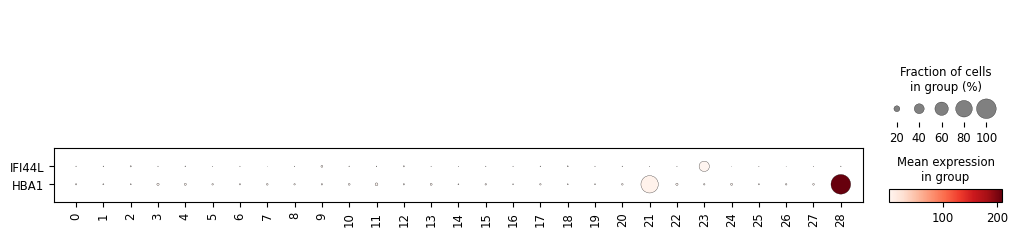

In [42]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['IFI44L', 'HBA1'], swap_axes = True)

### IFI44L Selection

In [43]:
em_ifi44l_adata, n_extracted = extract_cl(
    adata, 'IFI44L', 'above', 0.4, 'leiden_2'
)
em_ifi44l_adata.obs['AIFI_L3'] = 'ISG+ memory CD8 T cell'
n_extracted

6873

**Reassigned cells will be added to ISG+ cells below**

### IFI44L Removal

In [44]:
adata, n_removed = remove_cl(
    adata, 'IFI44L', 'above', 0.4, 'leiden_2'
)
n_removed

6873

### IFI44L Reason

In [45]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['ISG+ memory CD8 T cell']
    }
)
update_list.append(update_df)

### HBA1 Removal

In [46]:
adata, n_removed = remove_cl(
    adata, 'HBA1', 'above', 0.8, 'leiden_2'
)
n_removed

9570

### HBA1 Reason

In [47]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [48]:
adata = adata[adata.obs['AIFI_L3'] != 'GZMK+ CD27+ EM CD8 T cell']

In [49]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


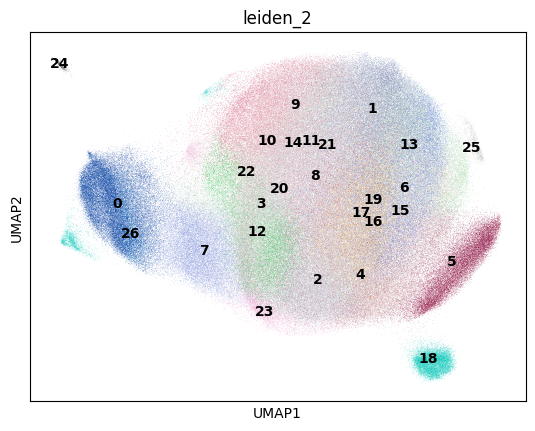

In [50]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [51]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review SOX4+ naive CD8 T cell

### Proposed updates

Remove high GZMB cluster as mislabeled

In [52]:
cell_type = 'SOX4+ naive CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [53]:
type_uuid

'54fe95b9-48ee-4d4e-a189-210b3482f13b'

In [54]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [55]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

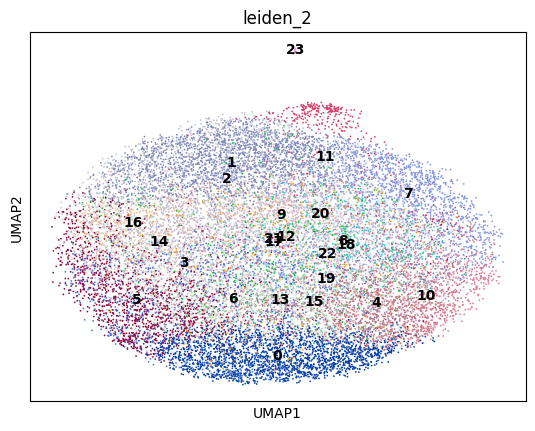

In [56]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

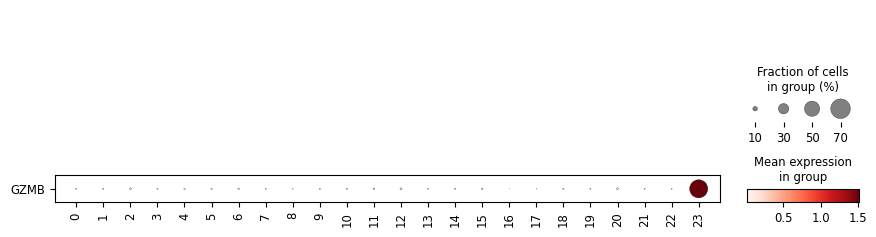

In [57]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['GZMB'], swap_axes = True)

### GZMB Removal

In [58]:
adata, n_removed = remove_cl(
    adata, 'GZMB', 'above', 0.6, 'leiden_2'
)
n_removed

27

### GZMB reason

In [59]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Mislabeled GZMB+']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [60]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


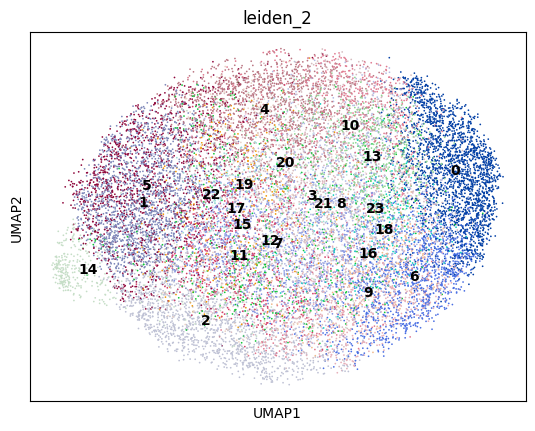

In [61]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [62]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

# Integrate

## Integrate GZMK+ CD27+ EM CD8 T cell

### Proposed updates

No suggested changes; Integrate transfered cells from other types

In [63]:
cell_type = 'GZMK+ CD27+ EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [64]:
type_uuid

'fc43bd5d-a792-4974-9a52-c5a213b9c331'

In [65]:
adata = read_adata_uuid(type_uuid)

In [66]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Combine cells from filtered groups

In [67]:
adata = sc.concat([adata, em_gzmk_adata])

### Reprocess combined cells

In [68]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; 

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Renormalizing


/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


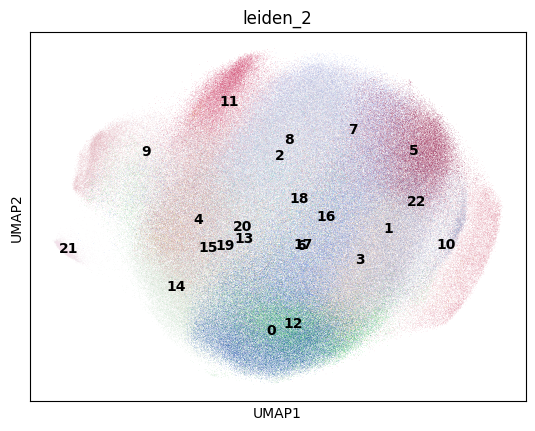

In [69]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

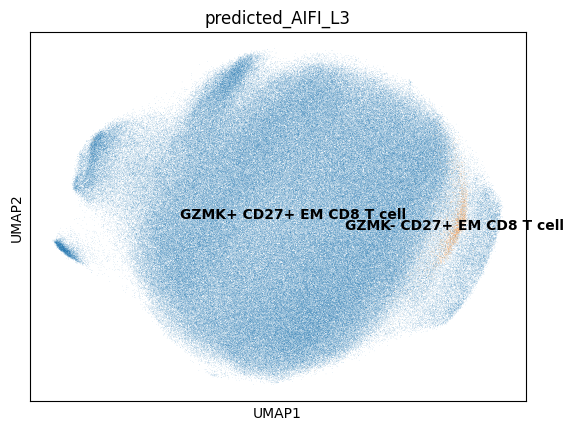

In [70]:
sc.pl.umap(adata, color = 'predicted_AIFI_L3', legend_loc = 'on data')

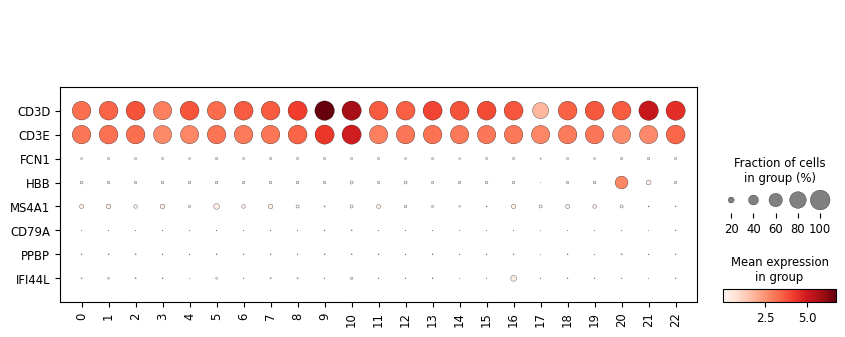

In [71]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

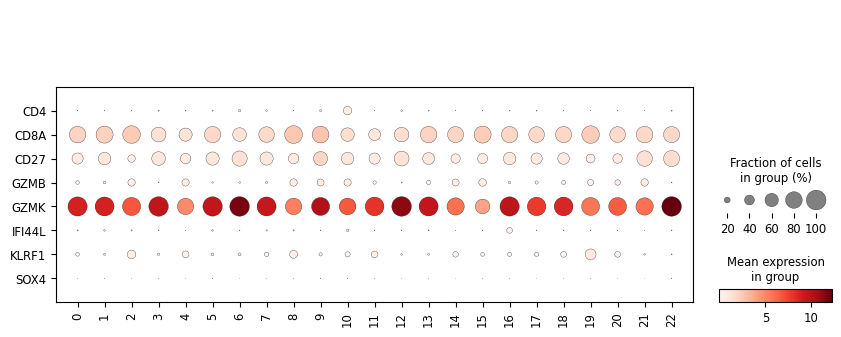

In [72]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Save combined cells

In [73]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

# No updates

## Pass-through CD8aa

### Proposed updates

No proposed changes

In [74]:
cell_type = 'CD8aa'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]
type_uuid

'87cfaf24-6a9d-4627-94c7-dc9869cedb70'

In [75]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


In [76]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through Core naive CD8 T cell

### Proposed updates

No proposed changes

In [77]:
cell_type = 'Core naive CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]
type_uuid

'ad480bbd-97dc-4447-b924-57e72310b395'

In [78]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


In [79]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through CM CD8 T cell

### Proposed updates

No proposed changes

In [80]:
cell_type = 'CM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]
type_uuid

'4ec77a6c-9f3e-4b84-ac6b-74b7bd067bfe'

In [81]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


In [82]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through ISG+ memory CD8 T cell

### Proposed updates

No proposed changes  

In [83]:
cell_type = 'ISG+ memory CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [84]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


In [85]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through ISG+ naive CD8 T cell

### Proposed updates

No proposed changes

In [86]:
cell_type = 'ISG+ naive CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]
type_uuid

'2dc30580-80d3-4133-ac53-aa65b55e4b95'

In [87]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


In [88]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through KLRF1+ GZMB+ CD27- EM CD8 T cell

### Proposed updates

No proposed changes

In [89]:
cell_type = 'KLRF1+ GZMB+ CD27- EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]
type_uuid

'1d057e47-1da6-4e03-b39c-c67e3646342e'

In [90]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:568: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


In [91]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Assemble update reasoning

In [92]:
update_df = pd.concat(update_list)

In [93]:
out_update = 'output/diha_filtered_celltypist_L3_CD8_reasons_{d}.csv'.format(d = date.today())
update_df.to_csv(out_update)
out_files.append(out_update)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [94]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CellTypist L3 CD8 Filtered {d}'.format(d = date.today())

In [95]:
search_id = element_id()
search_id

'plutonium-ruthenium-cesium'

In [96]:
in_files = search_df['id'].tolist()
in_files

['87cfaf24-6a9d-4627-94c7-dc9869cedb70',
 '4ec77a6c-9f3e-4b84-ac6b-74b7bd067bfe',
 'ad480bbd-97dc-4447-b924-57e72310b395',
 'bdb7cc5d-0812-43e2-a250-962224f3e2d6',
 'fc43bd5d-a792-4974-9a52-c5a213b9c331',
 '7a357af1-4791-4673-a0d6-a10a8a15cd6d',
 '2dc30580-80d3-4133-ac53-aa65b55e4b95',
 'b5bf5444-4f61-4775-99d3-f0b708ba3952',
 '1d057e47-1da6-4e03-b39c-c67e3646342e',
 '54fe95b9-48ee-4d4e-a189-210b3482f13b']

In [97]:
out_files

['output/diha_filtered_celltypist_L3_GZMKneg_CD27pos_EM_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_KLRF1neg_GZMBpos_CD27neg_EM_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_SOX4pos_naive_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_GZMKpos_CD27pos_EM_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_CD8aa_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_Core_naive_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_CM_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_ISGpos_memory_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_ISGpos_naive_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_KLRF1pos_GZMBpos_CD27neg_EM_CD8_T_cell_2024-04-18.h5ad',
 'output/diha_filtered_celltypist_L3_CD8_reasons_2024-04-18.csv']

In [ ]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

Cannot determine the current notebook.
1) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12c-Python_filter_L3_cd8_t_cell_data.ipynb
2) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12d-Python_filter_L3_other_t_cell_data.ipynb
3) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/11d-Python_review_L3_other_t_cell_data.ipynb
Please select (1-3) 


In [ ]:
import session_info
session_info.show()